In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from vit_pytorch import ViT, MAE

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import os
import fnmatch
import random
import einops

from torch import nn
from MS_SSIM import MS_SSIM

#### Data utils

In [2]:
def collect_paths(treeroot, pattern):
    results = []
    for base, _, files in os.walk(treeroot):
        goodfiles = fnmatch.filter(files, pattern)
        results.extend(os.path.join(base, f) for f in goodfiles)

    return results
    

class MinMaxNormalize:
    """Implementation of min-max normalization.
    """
    def __call__(self, sample):
        assert isinstance(sample, (torch.Tensor, np.ndarray)), "arg must be a torch.Tensor or np.ndarray"

        sample = (sample - sample.min()) / (sample.max() - sample.min())

        return sample


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
        MinMaxNormalize()
    ]
)


class XRaySet(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = self.transform(image)
        image = image.type(torch.float32)
        
        # print(image.shape)
        
        # image = einops.rearrange(image, "h w -> 1 h w")

        return image

#### Load data

In [3]:
batch_size = 10
train_subset_coeff = 0.95
path = "/home/student/Documents/xrays/data/preprocessed_images_train/"

In [4]:
get_train_idxs = lambda paths: round(len(paths) * train_subset_coeff)

paths = collect_paths(path, "*.png")
random.shuffle(paths)

train_paths = paths[:get_train_idxs(paths)]
test_paths = paths[get_train_idxs(paths)-len(paths):]

train_dataset = XRaySet(image_paths=train_paths, transform=transform)
test_dataset = XRaySet(image_paths=test_paths, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [5]:
v = ViT(
    channels=16,
    image_size = 125,
    patch_size = 25,
    num_classes = 6400,
    dim = 1024,
    depth = 6,
    heads = 1,
    mlp_dim = 256*5*5
)

v = v.cuda()

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
                
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=11, stride=1, padding=0),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=7, stride=1, padding=1),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, stride=1, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        ]).cuda()
        self.we_pool = lambda i: {0: True, 1: True, 2: True, 3: True, 4: True, 5: False}[i]
        
        self.linear_1 = nn.Linear(in_features=6400, out_features=400)
        self.linear_2 = nn.Linear(in_features=400, out_features=256*5*5)
        self.pool = nn.MaxPool2d(2, 2, return_indices=False)
        self.leaky_relu = nn.LeakyReLU() 

        self.unconvs = nn.ModuleList([
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=5, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=4, out_channels=2, kernel_size=5, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=5, stride=2, padding=1, output_padding=1)
        ])
        
    def conv_encoder(self, x):
        for ind,conv in enumerate(self.convs):
            x = conv(x)
            x = self.leaky_relu(x)
            if self.we_pool(ind):
                x = self.pool(x)
                
        return x

    def vit_encoder(self, x):
        x = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=6, stride=1, padding=0).cuda()(x)
        x = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=2, stride=1, padding=0).cuda()(x)
        x = self.pool(x)
        
        x = v(x)
        
        return x
        
    def mae_encoder(self, x):
        x_conved = Flatten()(new_mae(x))
        x_conved = nn.Linear(in_features=3072, out_features=6400).cuda()(x_conved)
        
        return x_conved
        
    def bottleneck(self, x):
        x = self.linear_1(x)
        h = self.leaky_relu(x)
        x = self.linear_2(h)
        
        return x
    
    def conv_decoder(self, x):
        for conv in self.unconvs:
            x = self.leaky_relu(x)
            x = conv(x)
        
        return torch.sigmoid(x)
       
    def forward(self, x):
        x_conved = self.conv_encoder(x)
        x_conved = Flatten()(x_conved)
        
        x_sa = self.vit_encoder(x)
        # x_sa = self.mae_encoder(x)
        x = x_sa + x_conved
        
        x = self.bottleneck(x)
        x = UnFlatten(c=256, h=5, w=5)(x)
        x = self.conv_decoder(x)
        
        return x

In [7]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def __call__(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def __init__(self, c, h, w):
        super(UnFlatten, self).__init__()
        self.c, self.h, self.w = c, h, w
        
    def __call__(self, input):
        return input.view(input.size(0), self.c, self.h, self.w)

In [8]:
model = Autoencoder()
model = model.cuda()

distance =  MS_SSIM()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=5e-4)

In [9]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print("Trainable parameters amount: {:n}".format(params))

Trainable parameters amount: 5983849


In [16]:
def fn(path):
    try:
        model.load_state_dict(torch.load(path))
    except Exception as err:
        print(err)

    res = model.forward(i)[0, ].cpu().detach().numpy()
    res = (res*255).astype(np.uint8)

    return Image.fromarray(res[0, ])

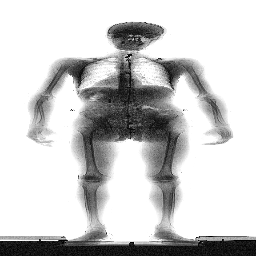

In [112]:
for j,i in enumerate(test_dataloader):
    i = i.cuda()
    
    if j % 680 == 0:
        break
    
image = i.clone()    
image = image.cpu().detach().numpy()
image = (image*255).astype(np.uint8)
Image.fromarray(image[0, 0,])

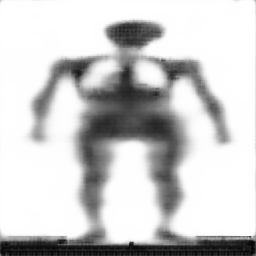

In [113]:
fn("ae+vit/ae+vit_100epo_256px.meow")

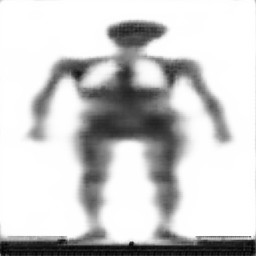

In [114]:
fn("ae+vit/ae+vit_200epo_256px.meow")

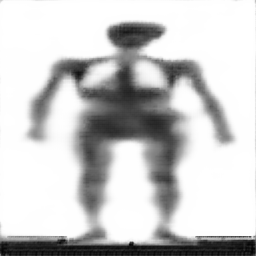

In [115]:
fn("ae+vit/ae+vit_300epo_256px.meow")

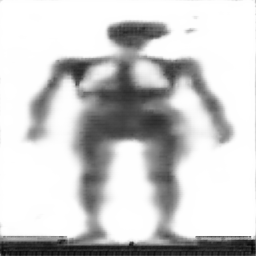

In [116]:
fn("ae+vit/ae+vit_850epo_256px.meow")

In [117]:
b = np.array(fn("ae+vit/ae+vit_850epo_256px.meow"))

In [118]:
c = b - np.array((i*255).cpu())[0, 0, :]

In [119]:
c.shape

(256, 256)

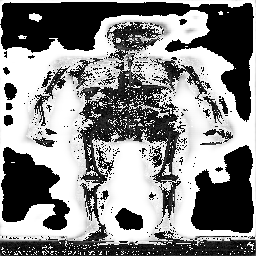

In [120]:
Image.fromarray(
    c.astype(np.uint8)
)

In [54]:
i

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.1135, 0.1185, 0.0464,  ..., 0.0402, 0.1745, 0.0853],
          [0.0506, 0.1345, 0.1375,  ..., 0.1224, 0.1201, 0.0724],
          [0.1203, 0.0788, 0.1336,  ..., 0.0229, 0.0996, 0.1531]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.1081, 0.1098, 0.0692,  ..., 0.0782, 0.0720, 0.0941],
          [0.0492, 0.0638, 0.0365,  ..., 0.0489, 0.0884, 0.0708],
          [0.0886, 0.0892, 0.0245,  ..., 0.0774, 0.0592, 0.0217]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..

In [52]:
torch.cuda.empty_cache()

num_epochs = 1000

save_step = 50

In [11]:
%%time
for epoch in range(num_epochs):
    loss_accumulator = []
    
    for data in train_dataloader:
        img = data.cuda()
        output = model(img)
        optimizer.zero_grad()
        
        # Don't forget about -1 if you are using SSIM-like losses!
        loss = -1 * distance(output, img)
        diff = -1 * loss.item()
        
        loss.backward()
        optimizer.step()
        # scheduler.step()       
        loss_accumulator.append(diff)
        
    if (epoch + 1) % save_step == 0:
        torch.save(new_mae.state_dict(), f"ae+vit/ae+vit_{epoch+1}epo_{256}px.meow")
           
    print('epoch [{}/{}], loss: {:.5f}'.format(epoch+1, num_epochs, np.mean(loss_accumulator)))
    
    with open("losses.txt", "a+") as file:
        file.write('epoch [{}/{}], loss: {:.5f}\n'.format(epoch+1, num_epochs, np.mean(loss_accumulator)))

epoch [1/1000], loss: 0.99896
epoch [2/1000], loss: 0.99965
epoch [3/1000], loss: 0.99977
epoch [4/1000], loss: 0.99978
epoch [5/1000], loss: 0.99979
epoch [6/1000], loss: 0.99979
epoch [7/1000], loss: 0.99979
epoch [8/1000], loss: 0.99979
epoch [9/1000], loss: 0.99979
epoch [10/1000], loss: 0.99982
epoch [11/1000], loss: 0.99985
epoch [12/1000], loss: 0.99988
epoch [13/1000], loss: 0.99990
epoch [14/1000], loss: 0.99991
epoch [15/1000], loss: 0.99991
epoch [16/1000], loss: 0.99992
epoch [17/1000], loss: 0.99992
epoch [18/1000], loss: 0.99992
epoch [19/1000], loss: 0.99993
epoch [20/1000], loss: 0.99993
epoch [21/1000], loss: 0.99993
epoch [22/1000], loss: 0.99993
epoch [23/1000], loss: 0.99993
epoch [24/1000], loss: 0.99994
epoch [25/1000], loss: 0.99994
epoch [26/1000], loss: 0.99994
epoch [27/1000], loss: 0.99994
epoch [28/1000], loss: 0.99994
epoch [29/1000], loss: 0.99994
epoch [30/1000], loss: 0.99994
epoch [31/1000], loss: 0.99995
epoch [32/1000], loss: 0.99995
epoch [33/1000], 

NameError: name 'new_mae' is not defined

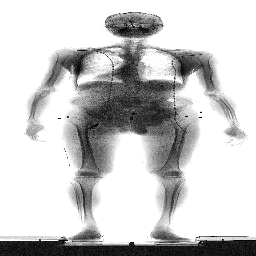

In [13]:
for i in test_dataloader:
    i = i.cuda()
    break
    
image = i.clone()
    
image = image.cpu().detach().numpy()
image = (image*255).astype(np.uint8)

Image.fromarray(image[0, 0,])

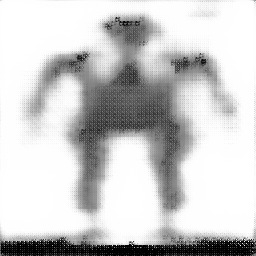

In [14]:
res = model.forward(i)[0, ].cpu().detach().numpy()
res = (res*255).astype(np.uint8)

Image.fromarray(res[0, ])

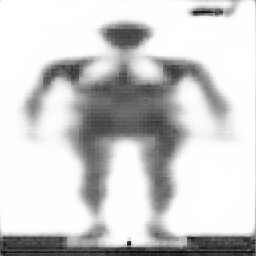

In [33]:
res = model.forward(i)[0, ].cpu().detach().numpy()
res = (res*255).astype(np.uint8)

Image.fromarray(res[0, ])

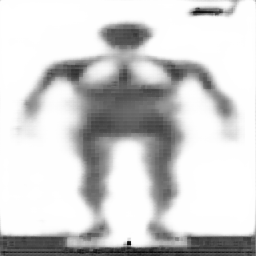

In [35]:
res = model.forward(i)[0, ].cpu().detach().numpy()
res = (res*255).astype(np.uint8)

Image.fromarray(res[0, ])

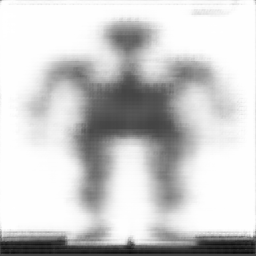

In [66]:
for i in test_dataloader:
    image = i.cuda()
    break
    
res = model.forward(image)
res.shape

res = model.forward(image)[0, ].cpu().detach().numpy()
res = (res*255).astype(np.uint8)

Image.fromarray(res[0, ])

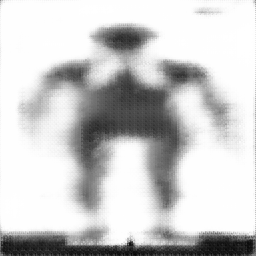

In [17]:
for i in test_dataloader:
    image = i.cuda()
    break
    
res = model.forward(image)
res.shape

res = model.forward(image)[0, ].cpu().detach().numpy()
res = (res*255).astype(np.uint8)

Image.fromarray(res[0, ])

#### Initialize entities

In [86]:
v = ViT(
    channels=1,
    image_size = 256,
    patch_size = 64,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 1,
    mlp_dim = 2048
)

In [15]:
from einops import repeat

class NewMAE(MAE):
    def __init__(self, encoder, masking_ratio, decoder_dim, decoder_depth):
        super().__init__(encoder=encoder, masking_ratio=masking_ratio, decoder_dim=decoder_dim, decoder_depth=decoder_depth)
        
    def forward(self, img):
        device = img.device

        # get patches

        patches = self.to_patch(img)
        batch, num_patches, *_ = patches.shape

        # patch to encoder tokens and add positions
        tokens = self.patch_to_emb(patches)
        tokens = tokens + self.encoder.pos_embedding[:, 1:(num_patches + 1)]

        # calculate of patches needed to be masked, and get random indices, dividing it up for mask vs unmasked

        num_masked = int(self.masking_ratio * num_patches)
        rand_indices = torch.rand(batch, num_patches, device = device).argsort(dim = -1)
        masked_indices, unmasked_indices = rand_indices[:, :num_masked], rand_indices[:, num_masked:]

        # get the unmasked tokens to be encoded

        batch_range = torch.arange(batch, device = device)[:, None]
        tokens = tokens[batch_range, unmasked_indices]

        # get the patches to be masked for the final reconstruction loss

        masked_patches = patches[batch_range, masked_indices]

        # attend with vision transformer

        encoded_tokens = self.encoder.transformer(tokens)
        
        return encoded_tokens

        # project encoder to decoder dimensions, if they are not equal - the paper says you can get away with a smaller dimension for decoder

        decoder_tokens = self.enc_to_dec(encoded_tokens)

        # reapply decoder position embedding to unmasked tokens

        decoder_tokens = decoder_tokens + self.decoder_pos_emb(unmasked_indices)

        # repeat mask tokens for number of masked, and add the positions using the masked indices derived above

        mask_tokens = repeat(self.mask_token, 'd -> b n d', b = batch, n = num_masked)
        mask_tokens = mask_tokens + self.decoder_pos_emb(masked_indices)

        # concat the masked tokens to the decoder tokens and attend with decoder

        # decoder_tokens = torch.cat((mask_tokens, decoder_tokens), dim = 1)
        decoded_tokens = self.decoder(decoder_tokens)
        
        restored_y = self.to_pixels(decoded_tokens)
        
        restored_y = einops.rearrange(
            restored_y,
            "b (h w) (p1 p2 c) -> b c (h p1) (w p2)",
            c=1, p1=64, p2=64, h=4, w=4
        )
                
        return restored_y    

In [88]:
new_mae = NewMAE(
    encoder = v,
    masking_ratio = 0.75,   # the paper recommended 75% masked patches
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

#### Training

In [63]:
# lr: from 0.01 to 0.00015625 in 10,000 epoches
optimizer = torch.optim.SGD(new_mae.parameters(), lr=0.03)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1700, gamma=0.5)

criterion = torch.nn.MSELoss()

epoches = 80  # ~36s на эпоху -> 100 часов -> 4 дня

verbose = 1
save_step = 100

In [64]:
%%time
losses = list()

for epoch in range(epoches):
    tmp_loss = list()
    
    for ind,image in enumerate(train_dataloader):
        optimizer.zero_grad()
        y_hat = new_mae(image)
        
        loss = criterion(y_hat, image)

        loss.backward()
        optimizer.step()
        
        tmp_loss.append(loss.item())
    
    loss_i = np.sum(tmp_loss) / len(tmp_loss)
    losses.append(loss_i)

    if (epoch + 1) % verbose == 0:
        print(f"Epoch: {epoch+1}  Epoch Loss: {loss_i}  Last Loss: {loss}")

    if (epoch + 1) % save_step == 0:
        torch.save(new_mae.state_dict(), f"mae_{epoch+1}epo_{256}px.meow")

Epoch: 1  Epoch Loss: 0.10553839270557676  Last Loss: 0.09156768023967743
Epoch: 2  Epoch Loss: 0.09127938960279737  Last Loss: 0.09093235433101654
Epoch: 3  Epoch Loss: 0.090864078274795  Last Loss: 0.08925381302833557
Epoch: 4  Epoch Loss: 0.09102600067853928  Last Loss: 0.09186345338821411
Epoch: 5  Epoch Loss: 0.0904762979064669  Last Loss: 0.08858540654182434
Epoch: 6  Epoch Loss: 0.09078189517770495  Last Loss: 0.09202457964420319
Epoch: 7  Epoch Loss: 0.09062715194055013  Last Loss: 0.09157344698905945
Epoch: 8  Epoch Loss: 0.09051816059010369  Last Loss: 0.09149792790412903
Epoch: 9  Epoch Loss: 0.09056555586201805  Last Loss: 0.09251020848751068
Epoch: 10  Epoch Loss: 0.09027941631419319  Last Loss: 0.09078246355056763
Epoch: 11  Epoch Loss: 0.09027282680783953  Last Loss: 0.09130683541297913
Epoch: 12  Epoch Loss: 0.09004895601953779  Last Loss: 0.0899943858385086
Epoch: 13  Epoch Loss: 0.0901579846228872  Last Loss: 0.0913277268409729
Epoch: 14  Epoch Loss: 0.090120049459593

KeyboardInterrupt: 

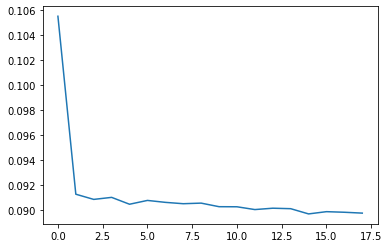

In [65]:
plt.plot(range(len(losses)), losses)

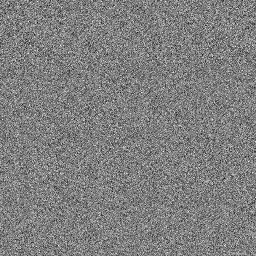

In [ ]:
for i in test_dataloader:
    image = i
    break
    
res = new_mae.forward(image)
res.shape

res = new_mae.forward(image)[0, ].detach().numpy()
res = (res*255).astype(np.uint8)

Image.fromarray(res[0, ])

In [80]:
import torch
from vit_pytorch import ViT
from vit_pytorch.simmim import SimMIM

v = ViT(
    image_size = 256,
    patch_size = 64,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    channels=1
)

mim = SimMIM(
    encoder = v,
    masking_ratio = 0.5  # they found 50% to yield the best results
)

In [81]:
# lr: from 0.01 to 0.00015625 in 10,000 epoches
optimizer = torch.optim.SGD(new_mae.parameters(), lr=0.03)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1700, gamma=0.5)

criterion = torch.nn.MSELoss()

epoches = 10  # ~36s на эпоху -> 100 часов -> 4 дня

verbose = 1
save_step = 100

In [82]:
%%time
losses = list()

for epoch in range(epoches):
    tmp_loss = list()
    
    for ind,image in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        loss = mim(image)
        loss.backward()
        
        optimizer.step()
        
        tmp_loss.append(loss.item())
    
    loss_i = np.sum(tmp_loss) / len(tmp_loss)
    losses.append(loss_i)

    if (epoch + 1) % verbose == 0:
        print(f"Epoch: {epoch+1}  Epoch Loss: {loss_i}  Last Loss: {loss}")

    if (epoch + 1) % save_step == 0:
        torch.save(new_mae.state_dict(), f"mae_{epoch+1}epo_{256}px.meow")

Epoch: 1  Epoch Loss: 0.12515743289675033  Last Loss: 0.12442521750926971
Epoch: 2  Epoch Loss: 0.12516885570117406  Last Loss: 0.12457853555679321
Epoch: 3  Epoch Loss: 0.125176340341568  Last Loss: 0.12510469555854797
Epoch: 4  Epoch Loss: 0.1252225222332137  Last Loss: 0.12491399794816971
Epoch: 5  Epoch Loss: 0.12521846379552568  Last Loss: 0.12542568147182465
Epoch: 6  Epoch Loss: 0.12512771891696112  Last Loss: 0.12472023814916611
Epoch: 7  Epoch Loss: 0.12527061785970414  Last Loss: 0.12556424736976624
Epoch: 8  Epoch Loss: 0.12526253291538783  Last Loss: 0.12532243132591248
Epoch: 9  Epoch Loss: 0.12515856219189508  Last Loss: 0.12511305510997772
Epoch: 10  Epoch Loss: 0.12506401432412012  Last Loss: 0.12491264194250107
CPU times: user 11min 40s, sys: 31.8 s, total: 12min 12s
Wall time: 2min 26s


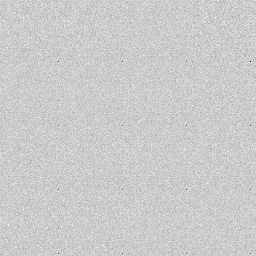

In [83]:
for i in test_dataloader:
    image = i
    break
    
res = new_mae.forward(image)
res.shape

res = new_mae.forward(image)[0, ].detach().numpy()
res = (res*255).astype(np.uint8)

Image.fromarray(res[0, ])

In [26]:
image.shape

torch.Size([83, 1, 256, 256])

In [27]:
ress = new_mae.predict(image)

In [ ]:
try:
    new_mae.load_state_dict(torch.load("mae_400epo_128px.meow"))
except Exception as err:
    print(err)

Error(s) in loading state_dict for NewMAE:
	size mismatch for encoder.pos_embedding: copying a param with shape torch.Size([1, 65, 1024]) from checkpoint, the shape in current model is torch.Size([1, 17, 1024]).
	size mismatch for encoder.to_patch_embedding.1.weight: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for patch_to_emb.weight: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for decoder_pos_emb.weight: copying a param with shape torch.Size([65, 512]) from checkpoint, the shape in current model is torch.Size([17, 512]).
	size mismatch for to_pixels.weight: copying a param with shape torch.Size([1024, 512]) from checkpoint, the shape in current model is torch.Size([4096, 512]).
	size mismatch for to_pixels.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current m

In [12]:
import os
os.path.isfile("mae_400epo_128px.meow")

True

In [122]:
ress = new_mae.predict(image)

In [126]:
ress.shape

torch.Size([32, 64, 512])

In [123]:
ress[0, :, :]

tensor([[ 0.5567,  0.1775,  0.1288,  ..., -0.0679, -1.7057, -1.2143],
        [-0.7014,  1.2137,  1.6712,  ..., -0.4900, -0.0740, -2.1348],
        [ 0.5336, -0.8650, -0.8314,  ...,  0.4156, -0.7537, -3.6591],
        ...,
        [-0.5351, -1.5570,  0.3770,  ...,  0.1683,  1.3772, -1.5451],
        [ 0.4989, -1.1258, -1.0677,  ...,  0.6227,  1.8376,  0.1923],
        [ 0.2310,  1.7438,  3.0634,  ...,  2.5852,  2.1672, -1.2609]],
       grad_fn=<SliceBackward0>)

In [112]:
g = (torch.sigmoid(ress[0, :, :]) * 255).to(int).numpy().astype(int)

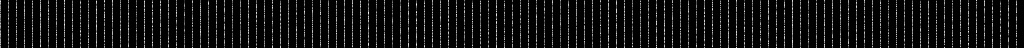

In [115]:
Image.fromarray((torch.sigmoid(ress[0, :, :]) * 255).to(int).numpy().astype(int), "L")

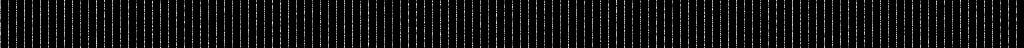

In [116]:
Image.fromarray((torch.sigmoid(ress[1, :, :]) * 255).to(int).numpy().astype(int), "L")

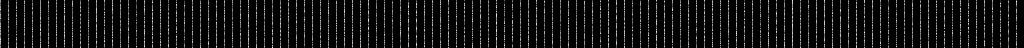

In [117]:
Image.fromarray((torch.sigmoid(ress[2, :, :]) * 255).to(int).numpy().astype(int), "L")

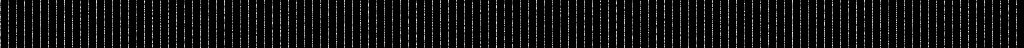

In [118]:
Image.fromarray((torch.sigmoid(ress[3, :, :]) * 255).to(int).numpy().astype(int), "L")

In [107]:
Image.fromarray(
    (torch.sigmoid(ress[0, :, :]) * 255).to(int).numpy().astype(int)
)

TypeError: Cannot handle this data type: (1, 1), <i8

In [20]:
optimizer = torch.optim.Adam(new_mae.parameters(), lr=0.001)

In [21]:
optimizer = torch.optim.Adam(new_mae.parameters(), lr=0.001)
epoches = 400  # 2 минуты на эпоху

%%time
for epoch in range(epoches):
    for ind,image in enumerate(train_dataloader):
        loss = new_mae(image)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
    
    print(f"Epoch: {epoch+1}   Loss: {loss}")

In [22]:
%%time
for epoch in range(epoches):
    for ind,image in enumerate(train_dataloader):
        loss = new_mae(image)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
    
    print(f"Epoch: {epoch+1}   Loss: {loss}")

Epoch: 1   Loss: 36719112192.0
Epoch: 2   Loss: 62169464832.0
Epoch: 3   Loss: 23433037824.0
Epoch: 4   Loss: 27279239168.0
Epoch: 5   Loss: 20387041280.0
Epoch: 6   Loss: 10396488704.0
Epoch: 7   Loss: 20026593280.0
Epoch: 8   Loss: 37190115328.0
Epoch: 9   Loss: 37735559168.0
Epoch: 10   Loss: 21499596800.0
Epoch: 11   Loss: 26447243264.0
Epoch: 12   Loss: 17495832576.0
Epoch: 13   Loss: 38293225472.0
Epoch: 14   Loss: 43633225728.0
Epoch: 15   Loss: 71133175808.0
Epoch: 16   Loss: 47734644736.0
Epoch: 17   Loss: 19009273856.0
Epoch: 18   Loss: 22250842112.0
Epoch: 19   Loss: 15529581568.0
Epoch: 20   Loss: 14008870912.0
Epoch: 21   Loss: 18508853248.0
Epoch: 22   Loss: 16211449856.0
Epoch: 23   Loss: 13229408256.0
Epoch: 24   Loss: 13100295168.0
Epoch: 25   Loss: 12586784768.0
Epoch: 26   Loss: 32031133696.0
Epoch: 27   Loss: 68275105792.0
Epoch: 28   Loss: 69647376384.0
Epoch: 29   Loss: 38938419200.0
Epoch: 30   Loss: 43537924096.0
Epoch: 31   Loss: 28424325120.0
Epoch: 32   Loss:

In [1]:
torch.save(new_mae.state_dict(), "mae_1000_epoches.meow")

NameError: name 'torch' is not defined

In [13]:
for i in test_dataloader:
    image = i
    break

In [15]:
with torch.no_grad():
    res = mae.forward(image)

In [63]:
mae.decoder(v(image))

RuntimeError: Given normalized_shape=[512], expected input with shape [*, 512], but got input of size[32, 1000]

#### Encoder


In [66]:
mae.

Signature: mae.forward(img)
Docstring:
Defines the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
File:      ~/.local/lib/python3.8/site-packages/vit_pytorch/mae.py
Type:      method


In [41]:
with torch.no_grad():
    res = mae.encoder.forward(image)

In [42]:
np_res = np.array(res)

In [43]:
np_res = (np_res - np_res.min()) / (np_res.max() - np_res.min())

In [50]:
np_res_int = (np_res * 255).astype(np.uint8)

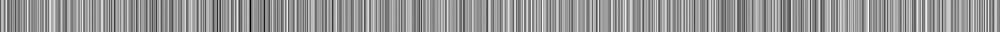

In [51]:
Image.fromarray(np_res_int)

#### E2D

In [77]:
einops.rearrange(res, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)

EinopsError:  Error while processing rearrange-reduction pattern "b c (h p1) (w p2) -> b (h w) (p1 p2 c)".
 Input tensor shape: torch.Size([32, 1000]). Additional info: {'p1': 32, 'p2': 32}.
 Expected 4 dimensions, got 2

In [67]:
with torch.no_grad():
    e2d_res = mae.enc_to_dec.forward(res)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1000 and 1024x512)

In [ ]:
class 

In [78]:
def predict(self, img):
    device = img.device

    # get patches

    patches = self.to_patch(img)
    batch, num_patches, *_ = patches.shape

    # patch to encoder tokens and add positions

    tokens = self.patch_to_emb(patches)
    tokens = tokens + self.encoder.pos_embedding[:, 1:(num_patches + 1)]

    # calculate of patches needed to be masked, and get random indices, dividing it up for mask vs unmasked

    num_masked = int(self.masking_ratio * num_patches)
    rand_indices = torch.rand(batch, num_patches, device = device).argsort(dim = -1)
    masked_indices, unmasked_indices = rand_indices[:, :num_masked], rand_indices[:, num_masked:]

    # get the unmasked tokens to be encoded

    batch_range = torch.arange(batch, device = device)[:, None]
    tokens = tokens[batch_range, unmasked_indices]

    # get the patches to be masked for the final reconstruction loss

    masked_patches = patches[batch_range, masked_indices]

    # attend with vision transformer

    encoded_tokens = self.encoder.transformer(tokens)

    # project encoder to decoder dimensions, if they are not equal - the paper says you can get away with a smaller dimension for decoder

    decoder_tokens = self.enc_to_dec(encoded_tokens)

    # reapply decoder position embedding to unmasked tokens

    decoder_tokens = decoder_tokens + self.decoder_pos_emb(unmasked_indices)

    # repeat mask tokens for number of masked, and add the positions using the masked indices derived above

    mask_tokens = repeat(self.mask_token, 'd -> b n d', b = batch, n = num_masked)
    mask_tokens = mask_tokens + self.decoder_pos_emb(masked_indices)

    # concat the masked tokens to the decoder tokens and attend with decoder

    decoder_tokens = torch.cat((mask_tokens, decoder_tokens), dim = 1)
    decoded_tokens = self.decoder(decoder_tokens)

    # splice out the mask tokens and project to pixel values

    mask_tokens = decoded_tokens[:, :num_masked]
    pred_pixel_values = self.to_pixels(mask_tokens)

    return pred_pixel_values

In [ ]:
class NewMAE()

In [127]:
mae.forward(image)

tensor(1.5113, grad_fn=<MseLossBackward0>)

In [75]:
for i in mae.children():
    print(i, end="\n\n\n\n")

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=192, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=64, out_features=1024, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=1024, out_features=2

In [68]:
mae.enc_to_dec?

Signature:      mae.enc_to_dec(*input, **kwargs)
Type:           Linear
String form:    Linear(in_features=1024, out_features=512, bias=True)
File:           ~/.local/lib/python3.8/site-packages/torch/nn/modules/linear.py
Docstring:     
Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

Args:
    in_features: size of each input sample
    out_features: size of each output sample
    bias: If set to ``False``, the layer will not learn an additive bias.
        Default: ``True``

Shape:
    - Input: :math:`(*, H_{in})` where :math:`*` means any number of
      dimensions including none and :math:`H_{in} = \text{in\_features}`.
    - Output: :math:`(*, H_{out})` where all but the last dimension
      are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

Attributes:
    weight: the learnable weights of the module of shape
        :math:`(\text{out\_features}, \text{in\_features})`. 

#### Decoder

In [33]:
a = next(iter(dataset))

In [47]:
b = (a.numpy() * 255).astype(np.uint8)

In [48]:
b = einops.rearrange(b, "c h w -> (c h) w")

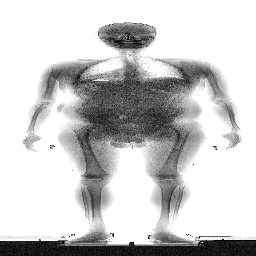

In [49]:
Image.fromarray(b)

In [47]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, sigma, channel):
    _1D_window = gaussian(window_size, sigma).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

class MS_SSIM(torch.nn.Module):
    def __init__(self, size_average = True, max_val = 255):
        super(MS_SSIM, self).__init__()
        self.size_average = size_average
        self.channel = 1
        self.max_val = max_val
    def _ssim(self, img1, img2, size_average = True):

        c, w, h = img1.size()
        window_size = min(w, h, 11)
        sigma = 1.5 * window_size / 11
        window = create_window(window_size, sigma, self.channel).cuda()
        mu1 = F.conv2d(img1, window, padding = window_size//2, groups = self.channel)
        mu2 = F.conv2d(img2, window, padding = window_size//2, groups = self.channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1*mu2

        sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = self.channel) - mu1_sq
        sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = self.channel) - mu2_sq
        sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = self.channel) - mu1_mu2

        C1 = (0.01*self.max_val)**2
        C2 = (0.03*self.max_val)**2
        V1 = 2.0 * sigma12 + C2
        V2 = sigma1_sq + sigma2_sq + C2
        ssim_map = ((2*mu1_mu2 + C1)*V1)/((mu1_sq + mu2_sq + C1)*V2)
        mcs_map = V1 / V2
        if size_average:
            return ssim_map.mean(), mcs_map.mean()

    def ms_ssim(self, img1, img2, levels=5):

        weight = Variable(torch.Tensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333]).cuda())

        msssim = Variable(torch.Tensor(levels,).cuda())
        mcs = Variable(torch.Tensor(levels,).cuda())
        for i in range(levels):
            ssim_map, mcs_map = self._ssim(img1, img2)
            msssim[i] = ssim_map
            mcs[i] = mcs_map
            filtered_im1 = F.avg_pool2d(img1, kernel_size=2, stride=2)
            filtered_im2 = F.avg_pool2d(img2, kernel_size=2, stride=2)
            img1 = filtered_im1
            img2 = filtered_im2

        value = (torch.prod(mcs[0:levels-1]**weight[0:levels-1])*
                                    (msssim[levels-1]**weight[levels-1]))
        return value


    def forward(self, img1, img2):

        return self.ms_ssim(img1, img2)